In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
from numpy import array_split

from eig import compute_eig_fast
from eig.battleship import Ship, BattleshipHypothesis, Parser, Executor
from eig.battleship.program import ProgramSyntaxError

from battleship.translator import Translator
from battleship.board import Board

In [4]:
# Configure matplotlib for retina
%config InlineBackend.figure_format = 'retina'

# Configure seaborn
sns.set_style('whitegrid')
sns.set_context('paper')

# Instantiate Translator

In [5]:
MODEL_NAME = "codellama/CodeLlama-7b-hf"
tokenizer, model = Translator.load_tokenizer_and_model(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [4]:
translator = Translator(model=model, tokenizer=tokenizer)

In [5]:
completions = translator.question_to_code("How many blocks is the blue ship?")
print(completions)

['(size Blue)']


In [6]:
completions = translator.question_to_code(["What color is A1?", "What color is A2?", "What color is A3?"])
print(completions)

['(color A-1)', '(color A-2)', '(color A-3)']


# Translate the question dataset

In [7]:
DATASET_PATH = "../question_dataset/df.allBySubj.csv"
DATASET_PATH_OUTPUT = "../question_dataset/df.allBySubj.withCode.csv"


QUESTION = "question"
CODE = "code"
SCORE = "score"

ORIGINAL = "original" # Original text
STANDARD = "standard" # Standardized text

In [8]:
df = pd.read_csv(DATASET_PATH)
df = df.rename(columns={"text": f"{QUESTION}_{ORIGINAL}", "full": f"{QUESTION}_{STANDARD}"})
df

,trial,subj,bin,type,paras,para_1,para_2,para_3,question_standard,question_original
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?
...,...,...,...,...,...,...,...,...,...,...
600,6,76,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,how big is the purple ship?
601,7,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship
602,8,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship?
603,9,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue boat


In [9]:
batch_size = 16

for question_type in [ORIGINAL, STANDARD]:
    completions = [translator.question_to_code(df_chunk[f"{QUESTION}_{question_type}"]) for df_chunk in tqdm(array_split(df, len(df) // batch_size))]
    df[f"{CODE}_{question_type}"] = [completion for chunk in completions for completion in chunk]


/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/37 [00:00<?, ?it/s]

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/37 [00:00<?, ?it/s]

In [10]:
# flatten completions and add to df
df.to_csv(DATASET_PATH_OUTPUT, index=False)

In [11]:
df

,trial,subj,bin,type,paras,para_1,para_2,para_3,question_standard,question_original,code_original,code_standard
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?,(size Red),(size Red)
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?,(== (orient Purple) H),(== (orient Purple) H)
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?,(size Red),(size Red)
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical,(== (orient Blue) V),(== (orient Blue) H)
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?,(size Purple),(size Purple)
...,...,...,...,...,...,...,...,...,...,...,...,...
600,6,76,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,how big is the purple ship?,(size Purple),(size Purple)
601,7,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship,(size Blue),(size Blue)
602,8,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship?,(size Blue),(size Blue)
603,9,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue boat,(size Blue),(size Blue)


# Compute EIG scores

In [6]:
def compute_score(trial_id, code):

    # Load the game board
    board_path = os.path.join("../question_dataset", "contexts", f"board_{trial_id}.txt")

    # Convert to numpy array
    board = pd.read_csv(board_path, header=None).values.astype(str)
    board = Board.convert_to_numeric(board)

    try:
        score = compute_eig_fast(code, board, grid_size=6, ship_labels=[1, 2, 3], ship_sizes=[2, 3, 4], orientations=['V', 'H'])
    except ProgramSyntaxError:
        score = 0
    except RuntimeError:
        score = 0

    return score

In [13]:
for question_type in [ORIGINAL, STANDARD]:
    for i, row in tqdm(df.iterrows(), total=len(df)):
        df.loc[i, f"{SCORE}_{question_type}"] = compute_score(trial_id=row["trial"], code=row[f"{CODE}_{question_type}"])

  0%|          | 0/605 [00:00<?, ?it/s]

  0%|          | 0/605 [00:00<?, ?it/s]

In [14]:
df.to_csv(DATASET_PATH_OUTPUT, index=False)

In [33]:
df_long = df.melt(id_vars=["trial", "question_original", "question_standard", "code_original", "code_standard"], value_vars=["score_original", "score_standard"], var_name="question_type", value_name="score")
df_long["question_type"] = df_long["question_type"].str.replace("score_", "")
df_long

,trial,question_original,question_standard,code_original,code_standard,question_type,score
0,1,How many blocks is the red ship?,How many tiles is the red ship?,(size Red),(size Red),original,1.360775
1,2,Is the purple ship laying horizontal?,Is the purple ship horizontal?,(== (orient Purple) H),(== (orient Purple) H),original,0.867056
2,3,How many blocks is the red ship?,How many tiles is the red ship?,(size Red),(size Red),original,1.439380
3,4,Is the blue ship vertical,Is the blue ship horizontal?,(== (orient Blue) V),(== (orient Blue) H),original,0.910715
4,5,How many blocks is the purple ship?,How many tiles is the purple ship?,(size Purple),(size Purple),original,1.568196
...,...,...,...,...,...,...,...
1205,6,how big is the purple ship?,How many tiles is the purple ship?,(size Purple),(size Purple),standard,1.584168
1206,7,how big is the blue ship,How many tiles is the blue ship?,(size Blue),(size Blue),standard,1.583411
1207,8,how big is the blue ship?,How many tiles is the blue ship?,(size Blue),(size Blue),standard,1.584963
1208,9,how big is the blue boat,How many tiles is the blue ship?,(size Blue),(size Blue),standard,1.578243


Text(0.5, 0, 'EIG Score')

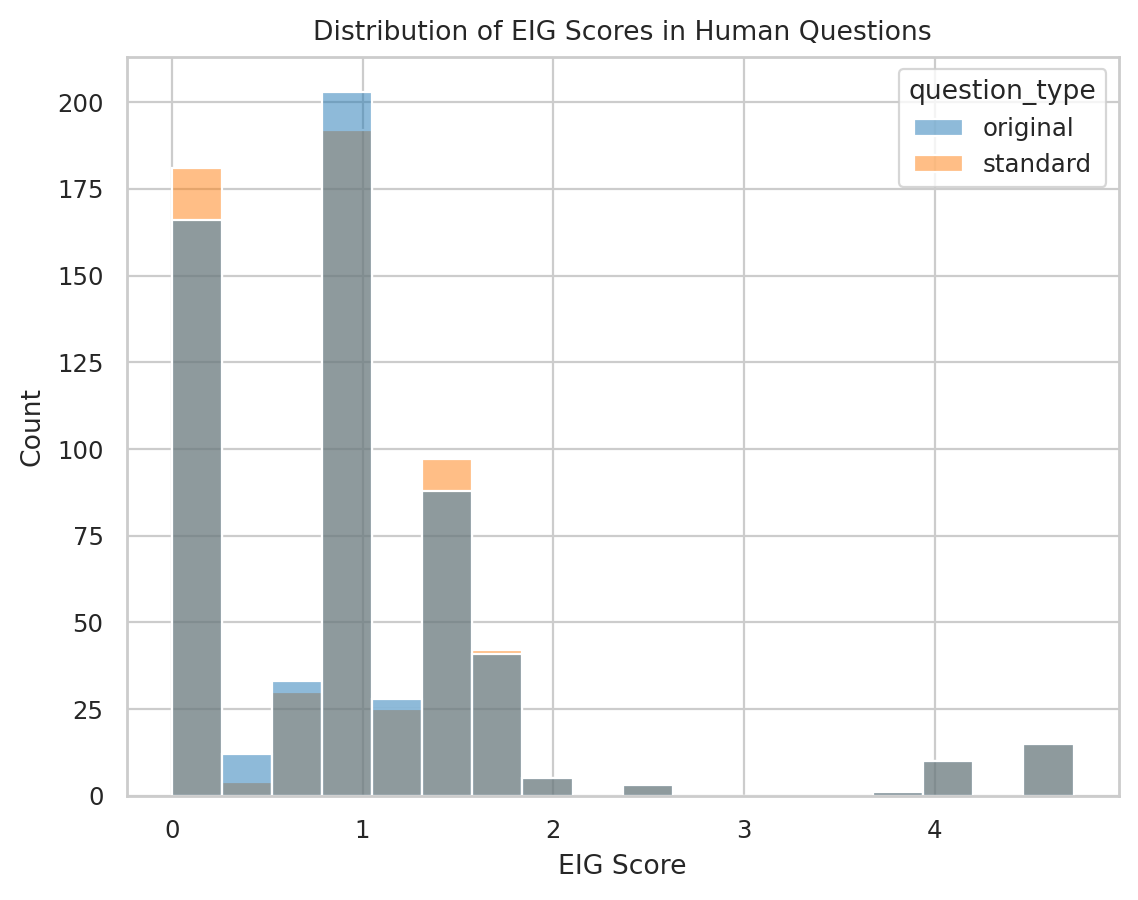

In [44]:
# Distribution of scores
sns.histplot(data=df_long, x=SCORE, hue="question_type")
plt.title("Distribution of EIG Scores in Human Questions")
plt.xlabel("EIG Score")